# Instalando


In [2]:
!pip install yfinance
!pip install tensorflow
!pip install pandas scikit-learn
!pip install factor_analyzer
!pip install sympy

In [114]:
import yfinance as yf
import pandas as pd
from yellowbrick.model_selection import LearningCurve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.preprocessing import MinMaxScaler

#CUDA GPUS
import tensorflow as tf
# Verifica se o TensorFlow consegue acessar a GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Cria um tensor
x = tf.random.uniform([3, 3])

# Verifica se o tensor está na GPU
print("Is the Tensor on GPU #0:  ", x.device.endswith('GPU:0'))

Num GPUs Available:  1
Is the Tensor on GPU #0:   True


# Coletando

In [37]:
#Escolha da ação

acao = 'VALE3.SA'
df = yf.Ticker(acao)

#escolher o intervalo de dados
data = df.history(period ='max')

#Filtrando 2008-2024
data = data.loc['2008-01-01':'2024-01-01']

#Removendo os campos dividendos e stock splits
data = data.drop(['Dividends', 'Stock Splits'], axis=1)

In [5]:
data.shape, data.isnull().sum()

((3970, 5),
 Open      0
 High      0
 Low       0
 Close     0
 Volume    0
 dtype: int64)

## Features novas

### Média movel

In [38]:
#Medias moveis criadas a partir do preço de fechamento e ja inserindo na tabela
data['MM7d'] = data['Close'].rolling(window=7).mean().round(2) #media movel 7 dias
data['MM15d'] = data['Close'].rolling(window=14).mean().round(2) #media movel 14 dias
data['MM30d'] = data['Close'].rolling(window=21).mean().round(2) #media movel 21 dias
data['MM60d'] = data['Close'].rolling(window=30).mean().round(2) #media movel 30 dias

### Retorno diário (Taxa de variação)

In [39]:
#criando coluna de retorno diário
taxa_variacao_diaria = data['Close'].pct_change().dropna()
taxa_variacao_7d = data['Close'].rolling(window=7).apply(lambda x: x[-1]/x[0] - 1)
taxa_variacao_14d = data['Close'].rolling(window=14).apply(lambda x: x[-1]/x[0] - 1)
taxa_variacao_30d = data['Close'].rolling(window=30).apply(lambda x: x[-1]/x[0] - 1)

#Inserindo na tabela
data['Variacao_Diaria'] = taxa_variacao_diaria
data['Variacao_7d'] = taxa_variacao_7d
data['Variacao_14d'] = taxa_variacao_14d
data['Variacao_30d'] = taxa_variacao_30d
data.tail(2)

C:\Users\joaov\AppData\Local\Temp\ipykernel_33124\751651109.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  taxa_variacao_7d = data['Close'].rolling(window=7).apply(lambda x: x[-1]/x[0] - 1)
C:\Users\joaov\AppData\Local\Temp\ipykernel_33124\751651109.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  taxa_variacao_14d = data['Close'].rolling(window=14).apply(lambda x: x[-1]/x[0] - 1)
C:\Users\joaov\AppData\Local\Temp\ipykernel_33124\751651109.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFr

,Open,High,Low,Close,Volume,MM7d,MM15d,MM30d,MM60d,Variacao_Diaria,Variacao_7d,Variacao_14d,Variacao_30d
Date,,,,,,,,,,,,,
2023-12-27 00:00:00-03:00,70.967076,71.613494,70.967076,71.474976,13821200,70.03,68.75,68.47,68.51,0.009653,0.042986,0.066116,0.061927
2023-12-28 00:00:00-03:00,71.105589,71.530374,70.874726,71.290276,16545800,70.42,69.06,68.64,68.64,-0.002584,0.033052,0.060439,0.052178


### RSI

In [40]:
period_rsi = 14

data['Close Diff'] = data['Close'].diff()

# Calcule o ganho (positivo) e a perda (negativo)
gain = data['Close Diff'].clip(lower=0)
loss = -data['Close Diff'].clip(upper=0)

# Calcule as médias móveis das variações positivas e negativas
avg_gain = gain.rolling(window=period_rsi, min_periods=1).mean()
avg_loss = loss.rolling(window=period_rsi, min_periods=1).mean()

# Calcular RS (evitando divisões por zero)
rs = avg_gain / avg_loss

# Evitar NaNs no RSI: se avg_loss for zero, considere RSI como 100
data['RSI'] = 100 - (100 / (1 + rs))
data.loc[avg_loss == 0, 'RSI'] = 100

# Conferir o número de NaNs após esse ajuste
print(f'Número de NaNs no RSI após ajuste: {data["RSI"].isna().sum()}')

# Preencher valores NaN restantes (se houver) com 0, caso necessário
data['RSI'].fillna(0, inplace=True)

data = data.drop(columns='Close Diff')


Número de NaNs no RSI após ajuste: 1


C:\Users\joaov\AppData\Local\Temp\ipykernel_33124\1279634046.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['RSI'].fillna(0, inplace=True)


In [41]:
data.isna().sum()

Open                0
High                0
Low                 0
Close               0
Volume              0
MM7d                6
MM15d              13
MM30d              20
MM60d              29
Variacao_Diaria     1
Variacao_7d         6
Variacao_14d       13
Variacao_30d       29
RSI                 0
dtype: int64

In [42]:
data = data.drop(columns=['Close Diff'])

data.tail(3)

KeyError: "['Close Diff'] not found in axis"

### Oscilação estocástica %K

In [43]:
def calculate_stochastic_K(data, period=14):
    # Calcula a mínima e máxima nos últimos 14 períodos
    data['Lowest'] = data['Close'].rolling(window=period).min()
    data['Highest'] = data['Close'].rolling(window=period).max()

    # Calcula o %K
    data['Stochastic_K'] = ((data['Close'] - data['Lowest']) / (data['Highest'] - data['Lowest'])) * 100

    return data

calculate_stochastic_K(data, 14)
data = data.drop(columns=['Lowest', 'Highest'])

In [44]:
def calculate_stochastic_K(data, period=14):
    # Calcula a mínima e máxima nos últimos N períodos
    data['Lowest'] = data['Close'].rolling(window=period).min()
    data['Highest'] = data['Close'].rolling(window=period).max()

    # Evita divisões por zero
    data['Stochastic_K'] = 100 * (data['Close'] - data['Lowest']) / (data['Highest'] - data['Lowest'])
    
    # Substituir valores onde High == Low (para evitar divisão por zero)
    data['Stochastic_K'] = data['Stochastic_K'].replace([float('inf'), -float('inf')], 0).fillna(0)

    # Remove as colunas temporárias
    data = data.drop(columns=['Lowest', 'Highest'])
    
    return data

# Aplicar a função ao DataFrame
data = calculate_stochastic_K(data, 14)


In [45]:
data.shape, data.isna().sum()

((3970, 15),
 Open                0
 High                0
 Low                 0
 Close               0
 Volume              0
 MM7d                6
 MM15d              13
 MM30d              20
 MM60d              29
 Variacao_Diaria     1
 Variacao_7d         6
 Variacao_14d       13
 Variacao_30d       29
 RSI                 0
 Stochastic_K        0
 dtype: int64)

In [46]:
data.head(30)

,Open,High,Low,Close,Volume,MM7d,MM15d,MM30d,MM60d,Variacao_Diaria,Variacao_7d,Variacao_14d,Variacao_30d,RSI,Stochastic_K
Date,,,,,,,,,,,,,,,
2008-01-02 00:00:00-02:00,24.795291,24.812030,24.083864,24.230335,1200600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2008-01-03 00:00:00-02:00,24.297295,24.632083,24.226151,24.355883,1114700,NaN,NaN,NaN,NaN,0.005181,NaN,NaN,NaN,100.000000,0.000000
2008-01-04 00:00:00-02:00,24.565125,24.690670,23.309667,23.477060,2110200,NaN,NaN,NaN,NaN,-0.036083,NaN,NaN,NaN,12.500119,0.000000
2008-01-07 00:00:00-02:00,23.636078,23.728145,22.464318,23.058567,2499900,NaN,NaN,NaN,NaN,-0.017826,NaN,NaN,NaN,8.823577,0.000000
2008-01-08 00:00:00-02:00,23.435212,23.903916,23.414288,23.518909,2514700,NaN,NaN,NaN,NaN,0.019964,NaN,NaN,NaN,31.111307,0.000000
2008-01-09 00:00:00-02:00,23.230149,23.514719,22.786555,23.267813,5417600,NaN,NaN,NaN,NaN,-0.010676,NaN,NaN,NaN,27.451119,0.000000
2008-01-10 00:00:00-02:00,23.393356,23.857873,23.184113,23.774178,4729300,23.67,NaN,NaN,NaN,0.021762,-0.018826,NaN,NaN,41.362832,0.000000
2008-01-11 00:00:00-02:00,23.811850,23.937396,23.460322,23.477060,3591900,23.56,NaN,NaN,NaN,-0.012497,-0.036083,NaN,NaN,37.179540,0.000000
2008-01-14 00:00:00-02:00,23.477055,23.853693,23.238519,23.435207,5678800,23.43,NaN,NaN,NaN,-0.001783,-0.001783,NaN,NaN,36.657304,0.000000


### Williams %R

In [47]:
# Função para calcular o índice de Williams %R
def williams_r(df, lookback_period=14):
    highest_high = df['High'].rolling(window=lookback_period).max()
    lowest_low = df['Low'].rolling(window=lookback_period).min()
    wr = -100 * ((highest_high - df['Close']) / (highest_high - lowest_low))
    return wr

In [48]:
data['Williams %R'] = williams_r(data)
data.tail(3)

,Open,High,Low,Close,Volume,MM7d,MM15d,MM30d,MM60d,Variacao_Diaria,Variacao_7d,Variacao_14d,Variacao_30d,RSI,Stochastic_K,Williams %R
Date,,,,,,,,,,,,,,,,
2023-12-26 00:00:00-03:00,71.253343,71.521137,70.791618,70.791618,12149500,69.56,68.42,68.29,68.30,0.003535,0.037910,0.059279,0.084329,79.719021,93.260857,-23.912946
2023-12-27 00:00:00-03:00,70.967076,71.613494,70.967076,71.474976,13821200,70.03,68.75,68.47,68.51,0.009653,0.042986,0.066116,0.061927,87.706019,100.000000,-12.422170
2023-12-28 00:00:00-03:00,71.105589,71.530374,70.874726,71.290276,16545800,70.42,69.06,68.64,68.64,-0.002584,0.033052,0.060439,0.052178,84.638298,95.651940,-15.527934


In [49]:
data.shape

### MACD

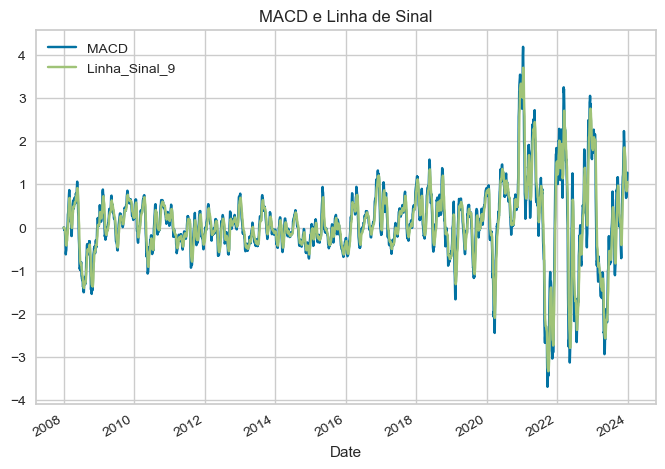

In [50]:
# Calcula as médias móveis exponenciais (EMA)
data['EMA12'] = data['Close'].ewm(span=12).mean()
data['EMA26'] = data['Close'].ewm(span=26).mean()

# Calcula o MACD 
data['MACD'] = data['EMA12'] - data['EMA26']

#Linha de sinal
data['Linha_Sinal_9'] = data['MACD'].ewm(span=9, adjust=False).mean()

# Plota o gráfico do MACD e linha de sinal
data[['MACD', 'Linha_Sinal_9']].plot(title='MACD e Linha de Sinal')

data = data.drop(columns=['EMA12', 'EMA26'])
data.tail(2)
data.shape

### Price RATE OF CHANGE

In [56]:
def calcular_roc(df, lookback_period=14):
    df['ROC'] = df['Close'].pct_change(periods=lookback_period) * 100
    return df

In [57]:
data = calcular_roc(data)
data.head(3)

,Open,High,Low,Close,Volume,MM7d,MM15d,MM30d,MM60d,Variacao_Diaria,Variacao_7d,Variacao_14d,Variacao_30d,RSI,Stochastic_K,Williams %R,MACD,Linha_Sinal_9,ROC,OBV
Date,,,,,,,,,,,,,,,,,,,,
2008-01-02 00:00:00-02:00,24.795291,24.812030,24.083864,24.230335,1200600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,0.000000,0.000000,NaN,0
2008-01-03 00:00:00-02:00,24.297295,24.632083,24.226151,24.355883,1114700,NaN,NaN,NaN,NaN,0.005181,NaN,NaN,NaN,100.000000,0.0,NaN,0.002817,0.000563,NaN,1114700
2008-01-04 00:00:00-02:00,24.565125,24.690670,23.309667,23.477060,2110200,NaN,NaN,NaN,NaN,-0.036083,NaN,NaN,NaN,12.500119,0.0,NaN,-0.023663,-0.004282,NaN,-995500


In [58]:
data.shape

### OBV ON BALANCE VOLUME

In [59]:
def calcular_obv(df):
    df['OBV'] = (np.where(df['Close'] > df['Close'].shift(1), df['Volume'],
                          np.where(df['Close'] < df['Close'].shift(1), -df['Volume'], 0))).cumsum()
    return df

In [60]:
data = calcular_obv(data)
data.head(10)
data.shape

### Direcao Target

In [61]:
# Calcula a diferença no preço de fechamento entre dias consecutivos
data['Direcao'] = data['Close'].diff()

# Mapeia a direção: 1 para aumento e 0 para queda ou estagnação
data['Direcao'] = data['Direcao'].apply(lambda x: 1 if x > 0 else 0)

# Ajusta a direção para prever o movimento do próximo dia
data['Direcao'] = data['Direcao'].shift(-5)

data.tail(10)

,Open,High,Low,Close,Volume,MM7d,MM15d,MM30d,MM60d,Variacao_Diaria,...,Variacao_14d,Variacao_30d,RSI,Stochastic_K,Williams %R,MACD,Linha_Sinal_9,ROC,OBV,Direcao
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-14 00:00:00-03:00,68.335242,68.575341,67.744235,67.781174,29454300,67.28,67.66,68.07,67.16,0.005480,...,0.001228,0.054163,47.208976,36.140422,-55.914013,0.685433,0.990344,-0.474572,967314132,1.0
2023-12-15 00:00:00-03:00,68.390643,68.612275,67.882750,68.205956,23279500,67.48,67.69,68.09,67.29,0.006267,...,0.005308,0.047658,54.371991,52.280554,-43.548579,0.689394,0.930154,0.750238,990593632,0.0
2023-12-18 00:00:00-03:00,68.390641,69.194044,68.067435,68.529160,16333400,67.69,67.74,68.12,67.41,0.004739,...,0.010347,0.048206,55.709770,64.561109,-34.140082,0.710423,0.886208,1.007198,1006927032,1.0
2023-12-19 00:00:00-03:00,68.981652,69.341796,68.676919,69.009361,21763700,67.95,67.83,68.10,67.53,0.007007,...,0.011916,0.076939,59.169083,82.806992,-20.161369,0.757110,0.860388,1.742693,1028690732,1.0
2023-12-20 00:00:00-03:00,69.009360,69.637306,68.787727,68.787727,14147900,68.16,67.87,67.98,67.69,-0.003212,...,-0.009705,0.072715,54.692090,74.385726,-26.613151,0.767380,0.841787,0.866627,1014542832,0.0
2023-12-21 00:00:00-03:00,69.674242,71.151766,69.554196,71.077888,24202600,68.69,67.98,68.08,67.92,0.033293,...,0.046784,0.103081,61.034009,100.000000,-1.512321,0.949372,0.863304,2.326508,1038745432,NaN
2023-12-22 00:00:00-03:00,71.225633,72.213723,70.449939,70.542282,26277000,69.13,68.17,68.16,68.12,-0.007535,...,0.048593,0.078244,70.967613,87.391182,-28.105580,1.038412,0.898325,3.889562,1012468432,NaN
2023-12-26 00:00:00-03:00,71.253343,71.521137,70.791618,70.791618,12149500,69.56,68.42,68.29,68.30,0.003535,...,0.059279,0.084329,79.719021,93.260857,-23.912946,1.116230,0.941906,5.229924,1024617932,NaN
2023-12-27 00:00:00-03:00,70.967076,71.613494,70.967076,71.474976,13821200,70.03,68.75,68.47,68.51,0.009653,...,0.066116,0.061927,87.706019,100.000000,-12.422170,1.218990,0.997323,6.950407,1038439132,NaN


In [62]:
data.isnull().sum()

Open                0
High                0
Low                 0
Close               0
Volume              0
MM7d                6
MM15d              13
MM30d              20
MM60d              29
Variacao_Diaria     1
Variacao_7d         6
Variacao_14d       13
Variacao_30d       29
RSI                 0
Stochastic_K        0
Williams %R        13
MACD                0
Linha_Sinal_9       0
ROC                14
OBV                 0
Direcao             5
dtype: int64

# PCA Correlações

In [63]:
data = data.dropna()

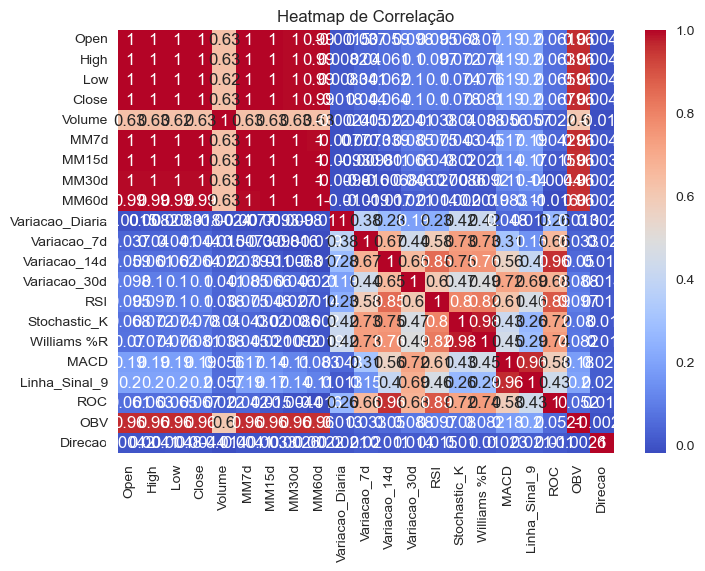

In [64]:
# Calcule a matriz de correlação
corr = data.corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Heatmap de Correlação')
plt.show()

## PCA - PREÇO + MEDIAS MOVEIS

In [65]:
# Essas variáveis são 100% iguais, pela correlação de pearson, por isso a criação de 1 fator que resuma as 4 em 1 variável
pca = data[['Open', 'High', 'Low', 'Close', 'MM7d', 'MM15d', 'MM30d', 'MM60d']]
pca.tail(2)

,Open,High,Low,Close,MM7d,MM15d,MM30d,MM60d
Date,,,,,,,,
2023-12-19 00:00:00-03:00,68.981652,69.341796,68.676919,69.009361,67.95,67.83,68.10,67.53
2023-12-20 00:00:00-03:00,69.009360,69.637306,68.787727,68.787727,68.16,67.87,67.98,67.69


In [66]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

#%% Teste de Esfericidade de Bartlett
bartlett, p_value = calculate_bartlett_sphericity(pca)
print(f'Qui² Bartlett: {round(bartlett, 2)}')
print(f'p-valor: {round(p_value, 4)}')

Qui² Bartlett: 202916.29
p-valor: 0.0


In [67]:
#%% Definindo a PCA (procedimento inicial extraindo todos os fatores possíveis)
fa = FactorAnalyzer(n_factors=4, method='principal', rotation=None).fit(pca)

In [68]:
#%% Obtendo os autovalores

autovalores = fa.get_eigenvalues()[0]

print(autovalores)

# Soma dos autovalores

round(autovalores.sum(), 2)

[7.98162603e+00 1.54888302e-02 1.67586256e-03 4.73864370e-04
 3.49919910e-04 2.47254803e-04 8.49793663e-05 5.32541803e-05]


In [69]:
import sympy as sy
import scipy as sp
#%% Obtendo os autovalores e autovetores: ilustrando o fundamento

## Atenção: esta célula tem fins didáticos, não é requerida na FactorAnalyzer

corr = pca.corr()

# Parametrizando o pacote

lamda = sy.symbols('lamda')
sy.init_printing(scale=0.8)

# Especificando a matriz de correlações

matriz = sy.Matrix(corr)
polinomio = matriz.charpoly(lamda)

polinomio

# Obtendo as raízes do polinômio característico: são os autovalores

autovalores, autovetores = sp.linalg.eigh(corr)
autovalores = autovalores[::-1]

# Obtendo os autovetores para cada autovalor extraído

autovetores = autovetores[:, ::-1]

In [70]:
#%% Eigenvalues, variâncias e variâncias acumuladas

autovalores_fatores = fa.get_factor_variance()

tabela_eigen = pd.DataFrame(autovalores_fatores)
tabela_eigen.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_eigen.columns)]
tabela_eigen.index = ['Autovalor','Variância', 'Variância Acumulada']
tabela_eigen = tabela_eigen.T

print(tabela_eigen)

         Autovalor  Variância  Variância Acumulada
Fator 1   7.981626   0.997703             0.997703
Fator 2   0.015489   0.001936             0.999639
Fator 3   0.001676   0.000209             0.999849
Fator 4   0.000474   0.000059             0.999908


C:\Users\joaov\AppData\Local\Temp\ipykernel_33124\2648249132.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=tabela_eigen.index, y=tabela_eigen['Variância'], data=tabela_eigen, palette='rocket')


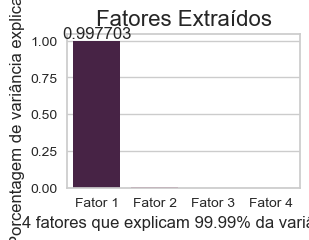

In [71]:
#%% Gráfico da variância acumulada dos componentes principais

plt.figure(figsize=(3,2))
ax = sns.barplot(x=tabela_eigen.index, y=tabela_eigen['Variância'], data=tabela_eigen, palette='rocket')
ax.bar_label(ax.containers[0])
plt.title("Fatores Extraídos", fontsize=16)
plt.xlabel(f"{tabela_eigen.shape[0]} fatores que explicam {round(tabela_eigen['Variância'].sum()*100,2)}% da variância", fontsize=12)
plt.ylabel("Porcentagem de variância explicada", fontsize=12)
plt.show()

In [72]:
#%% Determinando as cargas fatoriais

cargas_fatoriais = fa.loadings_

tabela_cargas = pd.DataFrame(cargas_fatoriais)
tabela_cargas.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_cargas.columns)]
tabela_cargas.index = pca.columns

print(tabela_cargas)

        Fator 1   Fator 2   Fator 3   Fator 4
Open   0.999215 -0.036129  0.003327  0.014613
High   0.999198 -0.037621  0.007340  0.000353
Low    0.999113 -0.039858  0.006340 -0.000252
Close  0.999015 -0.040712  0.008924 -0.014359
MM7d   0.999600 -0.004642 -0.024720  0.003644
MM15d  0.999301  0.029500 -0.020602 -0.004320
MM30d  0.998471  0.054251 -0.001813 -0.003153
MM60d  0.996892  0.075413  0.021266  0.003475


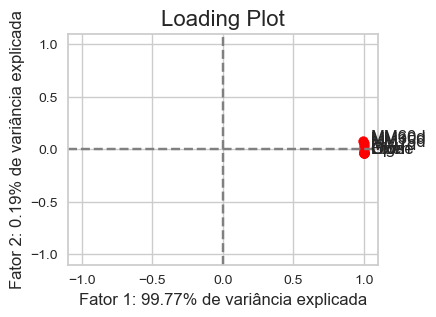

In [73]:
#%% Gráfico das cargas fatoriais (loading plot)

plt.figure(figsize=(4,3))
tabela_cargas_chart = tabela_cargas.reset_index()
plt.scatter(tabela_cargas_chart['Fator 1'], tabela_cargas_chart['Fator 2'], s=50, color='red')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + 0.05, point['y'], point['val'])

label_point(x = tabela_cargas_chart['Fator 1'],
            y = tabela_cargas_chart['Fator 2'],
            val = tabela_cargas_chart['index'],
            ax = plt.gca()) 

plt.axhline(y=0, color='grey', ls='--')
plt.axvline(x=0, color='grey', ls='--')
plt.ylim([-1.1,1.1])
plt.xlim([-1.1,1.1])
plt.title("Loading Plot", fontsize=16)
plt.xlabel(f"Fator 1: {round(tabela_eigen.iloc[0]['Variância']*100,2)}% de variância explicada", fontsize=12)
plt.ylabel(f"Fator 2: {round(tabela_eigen.iloc[1]['Variância']*100,2)}% de variância explicada", fontsize=12)
plt.show()

In [74]:
#%% Determinando as comunalidades

comunalidades = fa.get_communalities()

tabela_comunalidades = pd.DataFrame(comunalidades)
tabela_comunalidades.columns = ['Comunalidades']
tabela_comunalidades.index = pca.columns

print(tabela_comunalidades)

       Comunalidades
Open        0.999960
High        0.999866
Low         0.999856
Close       0.999975
MM7d        0.999845
MM15d       0.999916
MM30d       0.999901
MM60d       0.999945


In [75]:
#%% Extração dos fatores para as observações do banco de dados

fatores = pd.DataFrame(fa.transform(pca))
fatores.columns =  [f"Fator {i+1}" for i, v in enumerate(fatores.columns)]

# Adicionando os fatores ao banco de dados

preco_media = pd.concat([data.reset_index(drop=True), fatores], axis=1)

preco_media

,Open,High,Low,Close,Volume,MM7d,MM15d,MM30d,MM60d,Variacao_Diaria,...,Williams %R,MACD,Linha_Sinal_9,ROC,OBV,Direcao,Fator 1,Fator 2,Fator 3,Fator 4
0,23.389174,23.389174,22.748891,23.108789,1644000,23.05,22.40,21.84,22.38,-0.019357,...,-25.024331,0.314164,0.097085,22.711102,-5797000,1.0,-0.339940,-0.451241,0.096500,0.856540
1,24.686484,24.686484,24.075493,24.100603,1831700,23.36,22.62,21.92,22.37,0.042919,...,-12.173942,0.388583,0.155385,14.904227,-3965300,0.0,-0.305413,-1.033287,0.648266,1.352742
2,24.481427,24.858065,24.209410,24.234520,5031000,23.63,22.85,22.05,22.37,0.005557,...,-14.340712,0.452092,0.214726,15.243752,1065700,0.0,-0.299985,-1.024135,0.377519,0.791641
3,23.983420,25.113330,23.828579,25.109146,4362600,23.90,23.12,22.22,22.42,0.036090,...,-0.090894,0.561276,0.284036,17.462772,5428300,0.0,-0.293673,-0.998114,0.199862,-1.339879
4,25.523447,25.669916,24.736693,25.025448,3320000,24.13,23.34,22.39,22.49,-0.003333,...,-12.489879,0.633933,0.354016,14.143918,2108300,1.0,-0.271026,-1.286820,0.354239,1.113090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3931,68.335242,68.575341,67.744235,67.781174,29454300,67.28,67.66,68.07,67.16,0.005480,...,-55.914013,0.685433,0.990344,-0.474572,967314132,1.0,1.922080,-0.002410,0.377783,0.279653
3932,68.390643,68.612275,67.882750,68.205956,23279500,67.48,67.69,68.09,67.29,0.006267,...,-43.548579,0.689394,0.930154,0.750238,990593632,0.0,1.928582,-0.051792,0.446766,-0.176337
3933,68.390641,69.194044,68.067435,68.529160,16333400,67.69,67.74,68.12,67.41,0.004739,...,-34.140082,0.710423,0.886208,1.007198,1006927032,1.0,1.937957,-0.151765,0.583367,-0.557263
3934,68.981652,69.341796,68.676919,69.009361,21763700,67.95,67.83,68.10,67.53,0.007007,...,-20.161369,0.757110,0.860388,1.742693,1028690732,1.0,1.952264,-0.350136,0.748664,-0.275113


In [76]:
#%% Identificando os scores fatoriais

scores = fa.weights_

tabela_scores = pd.DataFrame(scores)
tabela_scores.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_scores.columns)]
tabela_scores.index = pca.columns

print(tabela_scores)

        Fator 1   Fator 2    Fator 3    Fator 4
Open   0.125189 -2.332570   1.985084  30.838399
High   0.125187 -2.428924   4.380033   0.745108
Low    0.125177 -2.573350   3.783181  -0.531482
Close  0.125164 -2.628448   5.325173 -30.301167
MM7d   0.125238 -0.299709 -14.750814   7.690382
MM15d  0.125200  1.904593 -12.293563  -9.116847
MM30d  0.125096  3.502604  -1.081670  -6.653620
MM60d  0.124898  4.868850  12.689534   7.333055


In [77]:
fator = preco_media['Fator 1']

# Ajustando base + TESTE E TREINO

In [78]:
# Colocando fatores e removendo variaveis do PCA
data = data.drop(columns=['Open', 'Close', 'Low', 'High', 'MM7d', 'MM15d', 'MM30d', 'MM60d'])

In [79]:
data = data.reset_index(drop=True)
fator_media = fator.reset_index(drop=True)
data['Fator_preco_media'] = fator
data.tail(2)

,Volume,Variacao_Diaria,Variacao_7d,Variacao_14d,Variacao_30d,RSI,Stochastic_K,Williams %R,MACD,Linha_Sinal_9,ROC,OBV,Direcao,Fator_preco_media
3934,21763700,0.007007,0.025666,0.011916,0.076939,59.169083,82.806992,-20.161369,0.75711,0.860388,1.742693,1028690732,1.0,1.952264
3935,14147900,-0.003212,0.020551,-0.009705,0.072715,54.692090,74.385726,-26.613151,0.76738,0.841787,0.866627,1014542832,0.0,1.955405


In [80]:
data.shape

## Padronização Z-score + treino e teste + time steps LSTM

In [81]:
#features retiradas para padronizar
input_data = data.drop(columns=['Direcao'])
input_data.tail(3)

,Volume,Variacao_Diaria,Variacao_7d,Variacao_14d,Variacao_30d,RSI,Stochastic_K,Williams %R,MACD,Linha_Sinal_9,ROC,OBV,Fator_preco_media
3933,16333400,0.004739,0.019368,0.010347,0.048206,55.709770,64.561109,-34.140082,0.710423,0.886208,1.007198,1006927032,1.937957
3934,21763700,0.007007,0.025666,0.011916,0.076939,59.169083,82.806992,-20.161369,0.757110,0.860388,1.742693,1028690732,1.952264
3935,14147900,-0.003212,0.020551,-0.009705,0.072715,54.692090,74.385726,-26.613151,0.767380,0.841787,0.866627,1014542832,1.955405


In [534]:
data.shape

In [82]:
from sklearn.preprocessing import StandardScaler
#Padronizando z-score
scaler_z = StandardScaler()
scaled_z_input_data = scaler_z.fit_transform(input_data.values)
scaled_z_input_data.shape

# retornando os dados normalizados do input com a direcao(target)
scaled_data = np.concatenate((scaled_z_input_data, data['Direcao'].values.reshape(-1, 1)), axis=1)

scaled_data.shape

x_data = scaled_z_input_data
y_data = data['Direcao']
x_data.shape, y_data.shape

In [83]:
x_data.shape, y_data.shape

In [85]:
# TRANSFORMANDO OS DADOS EM TRI DIMENSIONAL PARA O LSTM

timesteps = 30
features = data.shape[1] - 1

X = []
Y = []
for i in range(timesteps, len(x_data)):
    X.append(x_data[i-timesteps:i])
    Y.append(y_data[i])
X, Y = np.array(X), np.array(Y)

In [86]:
# Treino e teste LSTM
from sklearn.model_selection import train_test_split
x_train_lstm, x_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X, Y, test_size=0.1, shuffle=False)
x_train_lstm.shape, x_test_lstm.shape, y_train_lstm.shape, y_test_lstm.shape

In [87]:
# Treino e teste RANDOM FOREST E SVM
from sklearn.model_selection import train_test_split
x_train_acao, x_test_acao, y_train_acao, y_test_acao = train_test_split(x_data[30:], y_data[30:], test_size=0.1, shuffle=False) #Remoção de 30 dias para equilibrar
x_train_acao.shape, x_test_acao.shape, y_train_acao.shape, y_test_acao.shape

# VALIDAÇÃO FORWARD CROSS


## Bibliotecas + GPU

In [88]:
from sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC

In [89]:
# Verifique se há GPUs disponíveis
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs disponíveis: {gpus}")
else:
    print("Nenhuma GPU disponível. Utilizando CPU.")

GPUs disponíveis: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## LSTM

In [613]:
tscv = TimeSeriesSplit(n_splits=6)

param_grid_lstm = {
    'n_units': [50, 100],  # Número de unidades em cada camada LSTM
    'batch_size': [32, 64],  # lotes
    'epochs': [300],  #épocas
    'learning_rate': [0.001, 0.01],  # Taxa de aprendizado
    'optimizer': ['Adam', 'RMSprop', 'Adamax'],  # Otimizadores 
}


results = []
split_accuracies = []  # Para armazenar as acurácias de cada split
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Loop pelas combinações de hiperparâmetros
for params in ParameterGrid(param_grid_lstm):
    fold_accuracies = []
    fold_sizes = []  # Tamanho do conjunto de treinamento para cada split

    # Para cada combinação, aplicamos validação forward
    for fold_idx, (train_index, test_index) in enumerate(tscv.split(x_train_lstm)):
        X_train, X_test = x_train_lstm[train_index], x_train_lstm[test_index]
        y_train, y_test = y_train_lstm[train_index], y_train_lstm[test_index]

        # Armazenar o tamanho do conjunto de treinamento para este split
        fold_sizes.append(len(X_train))

        # Criar o modelo com os hiperparâmetros atuais
        model = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(params['n_units'], 
                                return_sequences=True, 
                                input_shape=(X_train.shape[1], X_train.shape[2]),
                                activation='tanh',
                                recurrent_activation='sigmoid'),  
            tf.keras.layers.LSTM(params['n_units'],
                                return_sequences=False,
                                activation='tanh',
                                recurrent_activation='sigmoid'), 
            tf.keras.layers.Dense(1, activation='sigmoid')  # Camada de saída com ativação sigmoid
        ])

        # Compile o modelo com o otimizador e taxa de aprendizado atual
        optimizer = getattr(tf.keras.optimizers, params['optimizer'])(learning_rate=params['learning_rate'])
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        # Treine o modelo com os parâmetros atuais
        model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], 
                  verbose=0, validation_data=(X_test, y_test), callbacks=[early_stopping])

        # Avaliar o modelo no conjunto de teste
        y_pred = model.predict(X_test)
        y_pred = (y_pred > 0.5).astype("int32")
        accuracy = np.mean(y_pred == y_test)

        # Armazenar a acurácia de cada fold
        fold_accuracies.append(accuracy)
        split_accuracies.append({'params': params, 'fold': fold_idx, 'train_size': len(X_train), 'accuracy': accuracy})

    # Calcular a média da acurácia em todos os folds
    mean_accuracy = np.mean(fold_accuracies)

    # Armazenar os resultados
    results.append({
        'params': params,
        'mean_accuracy': mean_accuracy,
        'fold_accuracies': fold_accuracies,
        'fold_sizes': fold_sizes
    })

# Ordenar os resultados para encontrar os melhores hiperparâmetros
best_params = sorted(results, key=lambda x: x['mean_accuracy'], reverse=True)[0]

print("Melhores parâmetros:", best_params['params'])
print("Melhor acurácia média:", best_params['mean_accuracy'])


16/16 [==============================] - 0s 5ms/step
Melhores parâmetros: {'batch_size': 32, 'epochs': 300, 'learning_rate': 0.01, 'n_units': 100, 'optimizer': 'Adam'}
Melhor acurácia média: 0.5152643079739475


In [614]:
best_params

{'params': {'batch_size': 32,
  'epochs': 300,
  'learning_rate': 0.01,
  'n_units': 100,
  'optimizer': 'Adam'},
 'mean_accuracy': 0.5152643079739475,
 'fold_accuracies': [0.5223805971333788,
  0.5051983301852352,
  0.5020475865462453,
  0.5001190457294329,
  0.547808764940239,
  0.5140315233091538],
 'fold_sizes': [507, 1009, 1511, 2013, 2515, 3017]}

### Gráficos

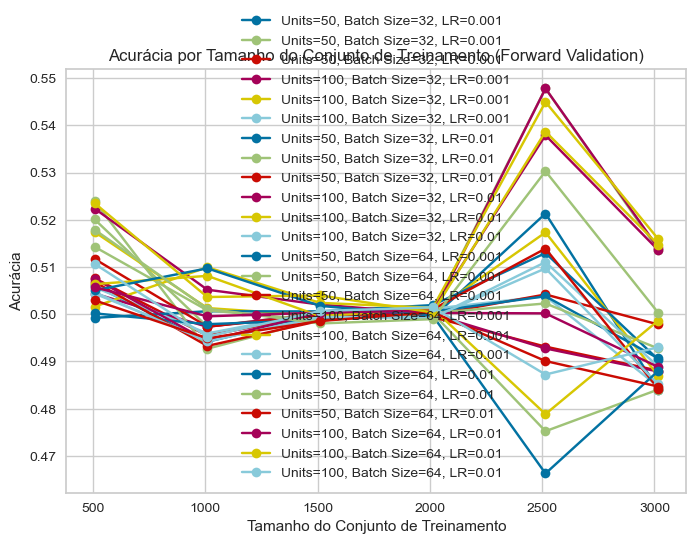

In [615]:
# Gráfico de acurácia por fold para cada combinação de hiperparâmetros
for result in results:
    fold_sizes = result['fold_sizes']
    fold_accuracies = result['fold_accuracies']
    label = f"Units={result['params']['n_units']}, Batch Size={result['params']['batch_size']}, LR={result['params']['learning_rate']}"
    plt.plot(fold_sizes, fold_accuracies, marker='o', label=label)

plt.title('Acurácia por Tamanho do Conjunto de Treinamento (Forward Validation)')
plt.xlabel('Tamanho do Conjunto de Treinamento')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()


## Random Forest

In [616]:
x_train_acao = pd.DataFrame(x_train_acao)
y_train_acao = pd.DataFrame(y_train_acao)

# Defina o TimeSeriesSplit para a validação forward
tscv = TimeSeriesSplit(n_splits=6)

# Parâmetros ideais para Random Forest com séries temporais financeiras
param_grid_rf = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [50, 100, 200, 300],  # Aumentar o número de estimadores para capturar variabilidade
    'max_depth': [2, 10, 20, 50],  # Variação na profundidade para evitar overfitting
    'min_samples_split': [2, 5, 10],  # Controla o número mínimo de amostras necessárias para dividir um nó
    'min_samples_leaf': [1, 2, 5],  # Define o número mínimo de amostras em uma folha
    'bootstrap': [True, False]  # Amostragem com substituição para robustez
}

# Lista para armazenar os resultados rf
results_rf = []

# Loop pelas combinações de hiperparâmetros
for params in ParameterGrid(param_grid_rf):
    fold_accuracies_rf = []
    fold_sizes_rf = []

    # Para cada combinação, aplicamos validação forward
    for train_index, test_index in tscv.split(x_train_acao):
        # Usar .iloc para garantir o acesso correto por posição numérica
        X_train, X_test = x_train_acao.iloc[train_index], x_train_acao.iloc[test_index]
        y_train, y_test = y_train_acao.iloc[train_index], y_train_acao.iloc[test_index]

        # Armazenar o tamanho do conjunto de treinamento para este split
        fold_sizes_rf.append(len(X_train))

        # Criar o modelo Random Forest com os hiperparâmetros atuais
        rf_model = RandomForestClassifier(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            min_samples_leaf=params['min_samples_leaf'],
            bootstrap=params['bootstrap'],
            random_state=1
        )

        # Treinar o modelo com os parâmetros atuais
        rf_model.fit(X_train, y_train.values.ravel())  # Certificar-se de que y_train está no formato correto

        # Prever a direção no conjunto de teste
        y_pred_rf = rf_model.predict(X_test)

        # Calcular a acurácia
        accuracy_rf = accuracy_score(y_test, y_pred_rf)

        # Armazenar a acurácia de cada fold
        fold_accuracies_rf.append(accuracy_rf)

    # Calcular a média da acurácia em todos os folds
    mean_accuracy_rf = np.mean(fold_accuracies_rf)

    # Armazenar os resultados
    results_rf.append({
        'params': params,
        'mean_accuracy': mean_accuracy_rf,
        'fold_accuracies': fold_accuracies_rf,
        'fold_sizes': fold_sizes_rf
    })

# Ordenar os resultados para encontrar os melhores hiperparâmetros
best_params_rf = sorted(results_rf, key=lambda x: x['mean_accuracy'], reverse=True)[0]

print("Melhores parâmetros (RF):", best_params_rf['params'])
print("Melhor acurácia média (RF):", best_params_rf['mean_accuracy'])


Melhores parâmetros (RF): {'bootstrap': False, 'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Melhor acurácia média (RF): 0.5132802124833997


In [ ]:
# Gráfico de acurácia por tamanho do conjunto de treinamento
for result in results_rf:
    plt.plot(result['fold_sizes'], result['fold_accuracies'], marker='o', 
             label=f"n_estimators={result['params']['n_estimators']}, max_depth={result['params']['max_depth']}, min_samples_split={result['params']['min_samples_split']}")

plt.title('Curva de Aprendizado: Acurácia por Tamanho do Conjunto de Treinamento (Random Forest)')
plt.xlabel('Tamanho do Conjunto de Treinamento')
plt.ylabel('Acurácia')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


## SVM

In [618]:
# transformação
x_train_acao = pd.DataFrame(x_train_acao)
y_train_acao = pd.DataFrame(y_train_acao)

# Definir TimeSeriesSplit para validação forward
tscv = TimeSeriesSplit(n_splits=6)

# parâmetros para o SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 50, 100, 200],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 5],  # Degree aplicável apenas ao kernel 'poly'
    'coef0': [0, 0.5],  # Coef0 aplicável apenas aos kernels 'poly' e 'sigmoid'
}

results_svm = []

# Loop pelas combinações de hiperparâmetros
for params in ParameterGrid(param_grid_svm):
    
    fold_accuracies_svm = []  # armazenar a acurácia em cada fold
    fold_sizes_svm = []  # armazenar o tamanho do conjunto de treino em cada fold

    
    for train_index, test_index in tscv.split(x_train_acao):

        X_train, X_test = x_train_acao.iloc[train_index], x_train_acao.iloc[test_index]
        y_train, y_test = y_train_acao.iloc[train_index], y_train_acao.iloc[test_index]

        fold_sizes_svm.append(len(X_train))

        # Ajustar degree e coef0 dependendo do kernel
        if params['kernel'] == 'poly':
            degree = params['degree']
            coef0 = params['coef0']
        elif params['kernel'] == 'sigmoid':
            degree = 3  
            coef0 = params['coef0']
        else:
            degree = 3
            coef0 = 0

        # Cria o modelo SVM com os hiperparâmetros atuais
        svm_model = SVC(
            C=params['C'],
            kernel=params['kernel'],
            gamma=params['gamma'],
            degree=degree,
            coef0=coef0,
            random_state=1
        )

        # Treina o modelo com os parâmetros atuais
        svm_model.fit(X_train, y_train.values.ravel())

        # Prevê a direção no conjunto de teste
        y_pred_svm = svm_model.predict(X_test)

        # acurácia
        accuracy_svm = accuracy_score(y_test, y_pred_svm)

        # Armazenar a acurácia de cada fold
        fold_accuracies_svm.append(accuracy_svm)

    # Calcular a média da acurácia em todos os folds
    mean_accuracy_svm = np.mean(fold_accuracies_svm)

    # Armazenar os resultados
    results_svm.append({
        'params': params,
        'mean_accuracy': mean_accuracy_svm,
        'fold_accuracies': fold_accuracies_svm,
        'fold_sizes': fold_sizes_svm
    })

# Ordenar os resultados para encontrar os melhores hiperparâmetros
best_params_svm = sorted(results_svm, key=lambda x: x['mean_accuracy'], reverse=True)[0]

print("Melhores parâmetros (SVM):", best_params_svm['params'])
print("Melhor acurácia média (SVM):", best_params_svm['mean_accuracy'])


Melhores parâmetros (SVM): {'C': 200, 'coef0': 0, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Melhor acurácia média (SVM): 0.5192563081009296


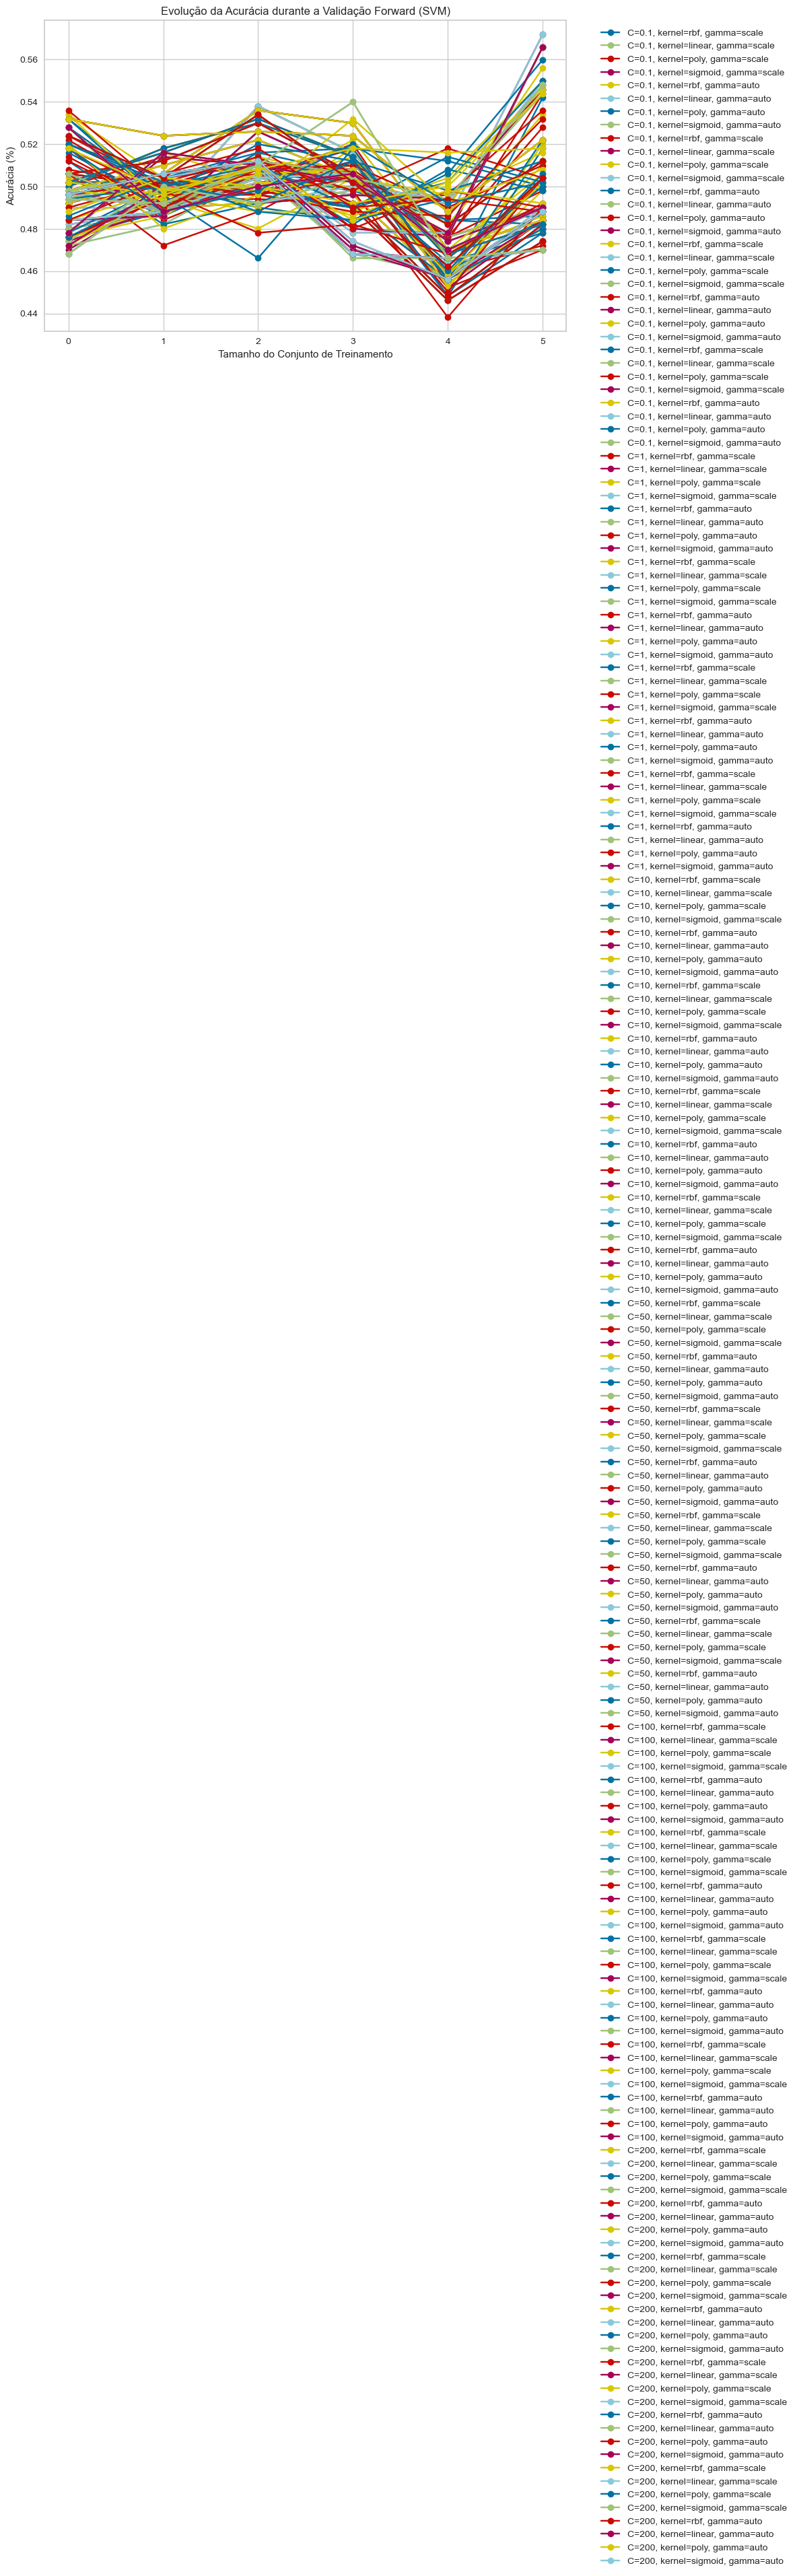

In [619]:
import matplotlib.pyplot as plt

# Inicializar a figura
plt.figure(figsize=(10, 6))

# Para cada resultado de validação forward (diferentes combinações de hiperparâmetros)
for result in results_svm:
    # Plotar a acurácia ao longo dos splits para cada combinação de hiperparâmetros
    plt.plot( result['fold_accuracies'], marker='o', linestyle='-', 
             label=f"C={result['params']['C']}, kernel={result['params']['kernel']}, gamma={result['params']['gamma']}")

# Configurações do gráfico
plt.title('Evolução da Acurácia durante a Validação Forward (SVM)')
plt.xlabel('Tamanho do Conjunto de Treinamento')
plt.ylabel('Acurácia (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.show()


## Gráficos do treinamento Validação Foward

In [620]:
best_params_rf

{'params': {'bootstrap': False,
  'criterion': 'gini',
  'max_depth': 50,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 100},
 'mean_accuracy': 0.5132802124833997,
 'fold_accuracies': [0.5537848605577689,
  0.4760956175298805,
  0.5438247011952191,
  0.5099601593625498,
  0.4760956175298805,
  0.5199203187250996],
 'fold_sizes': [507, 1009, 1511, 2013, 2515, 3017]}

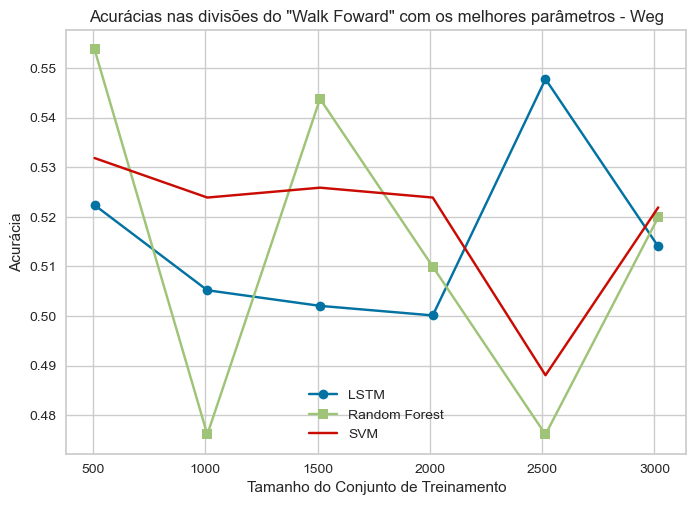

In [656]:
import matplotlib.pyplot as plt

# Melhor combinação de hiperparâmetros para LSTM
best_lstm_fold_sizes = best_params['fold_sizes']
best_lstm_fold_accuracies = best_params['fold_accuracies']

# Melhor combinação de hiperparâmetros para Random Forest
best_rf_fold_sizes = best_params_rf['fold_sizes']  # Supondo que você tenha armazenado as fold sizes e accuracies para RF
best_rf_fold_accuracies = best_params_rf['fold_accuracies']

# Melhor combinação de hiperparâmetros para SVM
best_svm_fold_sizes = best_params_svm['fold_sizes']  # Supondo que você tenha armazenado as fold sizes e accuracies para SVM
best_svm_fold_accuracies = best_params_svm['fold_accuracies']

# Gráfico da acurácia por fold para a melhor combinação de hiperparâmetros para LSTM
plt.plot(best_lstm_fold_sizes, best_lstm_fold_accuracies, marker='o', label="LSTM")

# Gráfico da acurácia por fold para a melhor combinação de hiperparâmetros para Random Forest
plt.plot(best_rf_fold_sizes, best_rf_fold_accuracies, marker='s', label="Random Forest")

# Gráfico da acurácia por fold para a melhor combinação de hiperparâmetros para SVM
plt.plot(best_svm_fold_sizes, best_svm_fold_accuracies, marker='x', label="SVM")

# Título e eixos
plt.title('Acurácias nas divisões do "Walk Forward" com os melhores parâmetros - Weg')
plt.xlabel('Tamanho do Conjunto de Treinamento')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()


Divisão 0: Treino tamanho: 507, Teste tamanho: 502
Acurácia na divisão 0: 0.8785
Divisão 1: Treino tamanho: 1009, Teste tamanho: 502
Acurácia na divisão 1: 0.8845
Divisão 2: Treino tamanho: 1511, Teste tamanho: 502
Acurácia na divisão 2: 0.8865
Divisão 3: Treino tamanho: 2013, Teste tamanho: 502
Acurácia na divisão 3: 0.8825
Divisão 4: Treino tamanho: 2515, Teste tamanho: 502
Acurácia na divisão 4: 0.8685
Divisão 5: Treino tamanho: 3017, Teste tamanho: 502
Acurácia na divisão 5: 0.8685


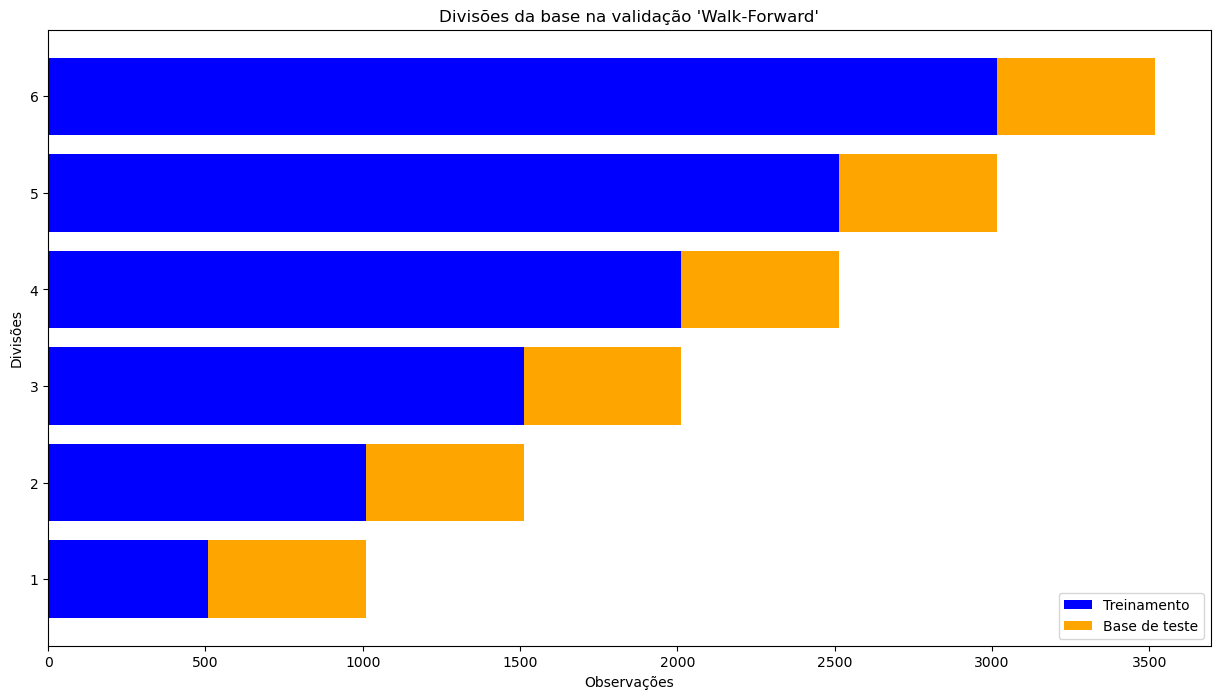

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification

# Gerar dados sintéticos (você pode substituir pelos seus dados)
X, y = make_classification(n_samples=3519, n_features=13, n_classes=2)

# Dividindo em 6 grupos usando TimeSeriesSplit para Walk Forward
n_splits = 6
tscv = TimeSeriesSplit(n_splits=n_splits)

split_num = 0
train_sizes = []
test_sizes = []

# Treinar e testar em cada split
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Apenas para ilustração, usando Regressão Logística como modelo
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"Divisão {split_num}: Treino tamanho: {len(train_index)}, Teste tamanho: {len(test_index)}")
    print(f"Acurácia na divisão {split_num}: {acc:.4f}")

    train_sizes.append(len(train_index))
    test_sizes.append(len(test_index))
    split_num += 1

# Visualização do Walk Forward como no gráfico que você enviou
plt.figure(figsize=(15, 8))
current_split = 1
for train_index, test_index in tscv.split(X):
    # Garantir que a legenda seja adicionada apenas uma vez
    plt.barh(current_split, len(train_index), left=0, color="blue", label="Treinamento" if current_split == 1 else "")
    plt.barh(current_split, len(test_index), left=len(train_index), color="orange", label="Base de teste" if current_split == 1 else "")
    current_split += 1

# Adicionar a legenda manualmente para garantir que apareça


plt.title("Divisões da base na validação 'Walk-Forward'")
plt.ylabel("Divisões")
plt.xlabel("Observações")
plt.legend(loc='lower right')
plt.show()


# Testando com os melhores parâmetros na VALIDAÇÃO 10% + Matriz de confusão

In [655]:
#----------------------MELHORES ACURACIAS MEDIAS DO TREINAMENTO WALK FOWARD -----------------------
print("Melhores parâmetros (SVM):", best_params_svm['params'])
print("Melhor acurácia média (SVM):", best_params_svm['mean_accuracy'])
print("Melhores parâmetros (RF):", best_params_rf['params'])
print("Melhor acurácia média (RF):", best_params_rf['mean_accuracy'])
print("Melhores parâmetros:(lstm)", best_params['params'])
print("Melhor acurácia média:(lstm)", best_params['mean_accuracy'])

Melhores parâmetros (SVM): {'C': 200, 'coef0': 0, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Melhor acurácia média (SVM): 0.5192563081009296
Melhores parâmetros (RF): {'bootstrap': False, 'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Melhor acurácia média (RF): 0.5132802124833997
Melhores parâmetros:(lstm) {'batch_size': 32, 'epochs': 300, 'learning_rate': 0.01, 'n_units': 100, 'optimizer': 'Adam'}
Melhor acurácia média:(lstm) 0.5152643079739475


## LSTM

In [112]:
#----------------- COM MELHORES PARAMETROS ------------------------------------
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True, input_shape=(x_train_lstm.shape[1], features)),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model_lstm.compile(optimizer= 'RMSprop', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm_g = model_lstm.fit(x_train_lstm, y_train_lstm, epochs=300, batch_size=320, validation_data = (x_test_lstm, y_test_lstm), callbacks=early_stopping)

Epoch 1/300
11/11 [==============================] - 3s 91ms/step - loss: 0.7017 - accuracy: 0.4802 - val_loss: 0.6902 - val_accuracy: 0.5115
Epoch 2/300
11/11 [==============================] - 0s 28ms/step - loss: 0.6947 - accuracy: 0.5095 - val_loss: 0.6971 - val_accuracy: 0.4885
Epoch 3/300
11/11 [==============================] - 0s 22ms/step - loss: 0.6945 - accuracy: 0.5050 - val_loss: 0.6893 - val_accuracy: 0.5371
Epoch 4/300
11/11 [==============================] - 0s 21ms/step - loss: 0.6936 - accuracy: 0.5178 - val_loss: 0.6937 - val_accuracy: 0.5422
Epoch 5/300
11/11 [==============================] - 0s 21ms/step - loss: 0.6931 - accuracy: 0.5201 - val_loss: 0.6886 - val_accuracy: 0.5422
Epoch 6/300
11/11 [==============================] - 0s 21ms/step - loss: 0.6916 - accuracy: 0.5226 - val_loss: 0.6859 - val_accuracy: 0.5601
Epoch 7/300
11/11 [==============================] - 0s 21ms/step - loss: 0.6924 - accuracy: 0.5209 - val_loss: 0.6886 - val_accuracy: 0.5166
Epoch 

In [113]:
y_pred_lstm = (model_lstm.predict(x_test_lstm) > 0.5).astype("int32") 
# LSTM
y_pred_lstm = (model_lstm.predict(x_test_lstm) > 0.5).astype("int32")
calcular_metricas('LSTM', y_true, y_pred_lstm)

13/13 [==============================] - 0s 10ms/step

LSTM Metrics:
Accuracy: 0.56
F1 Score: 0.58
Precision: 0.56
Recall (Sensibilidade): 0.60
Specificity (Especificidade): 0.52


## RF

In [96]:
x_train_acao.shape, y_train_acao.shape, x_test_acao.shape, y_test_acao.shape

In [97]:
rf_model_test = RandomForestClassifier(
    criterion = 'gini',
    bootstrap= False,
    max_depth= 20,
    min_samples_leaf= 2,
    min_samples_split= 2,
    n_estimators= 50,
    random_state=2
)
# Treinar o modelo na base de treino
rf_model_test.fit(x_train_acao, y_train_acao)

# Avaliar a acurácia na base de teste
accuracy = rf_model_test.score(x_test_acao, y_test_acao)
print(f'Acurácia na base de teste: {accuracy * 100:.2f}%')

Acurácia na base de teste: 48.34%


## SVM

In [99]:
from sklearn.svm import SVC

svm_model_test = SVC(probability=True)  

#  SVM com os melhores parâmetros
svm_model_test = SVC(
    C= 0.1,
    coef0= 0.5,
    degree= 2,
    gamma= 'auto',
    kernel= 'sigmoid',
)

svm_model_test.fit(x_train_acao, y_train_acao)
# acurácia
accuracy = svm_model_test.score(x_test_acao, y_test_acao)
print(f'Acurácia na base de teste: {accuracy * 100:.2f}%')

Acurácia na base de teste: 53.96%


## Matriz de confusão + Comparação com gráficos

13/13 [==============================] - 1s 12ms/step


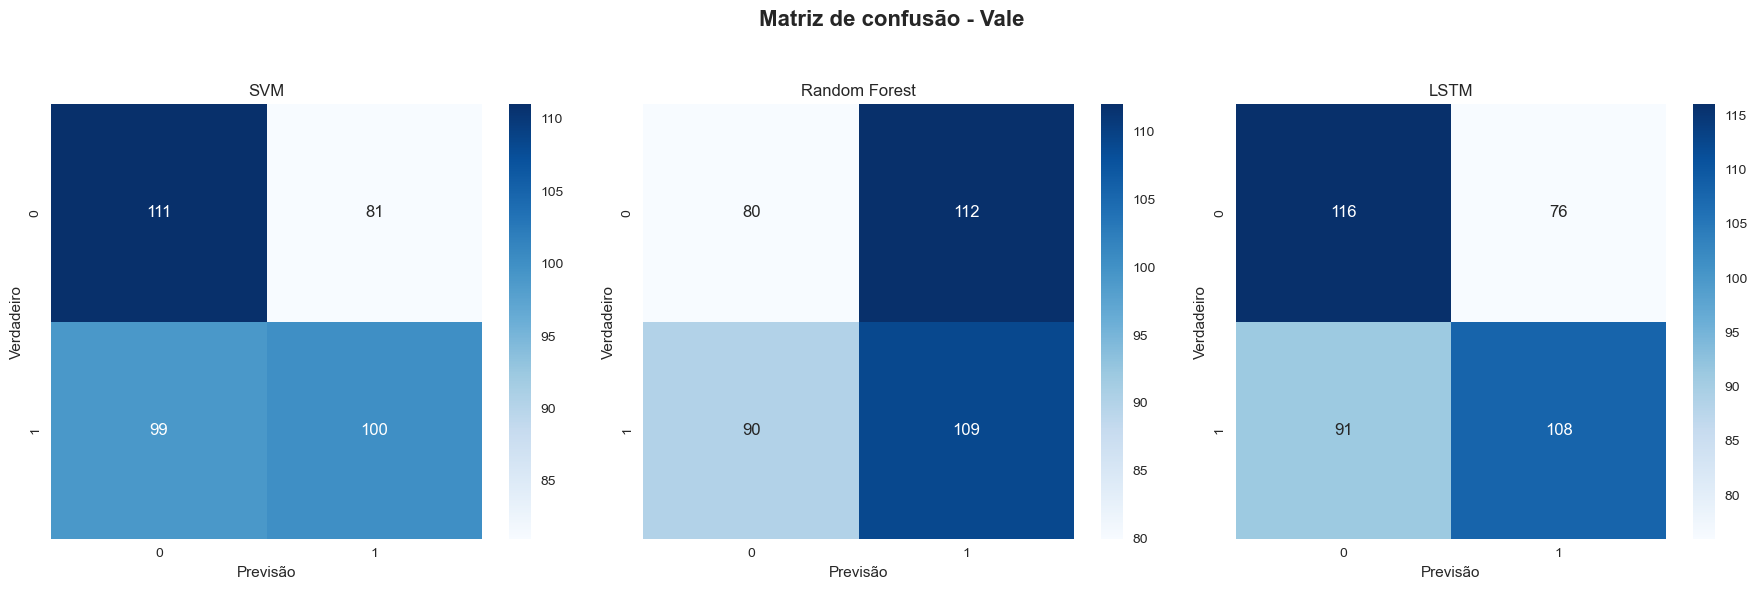

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Guardar as previsões
y_pred_svm = svm_model_test.predict(x_test_acao)
y_pred_rf = rf_model_test.predict(x_test_acao)
y_pred_lstm = (model_lstm.predict(x_test_lstm) > 0.5).astype("int32")

# Calcular as matrizes de confusão
cm_svm = confusion_matrix(y_test_acao, y_pred_svm)
cm_rf = confusion_matrix(y_test_acao, y_pred_rf)
cm_lstm = confusion_matrix(y_test_acao, y_pred_lstm)

# Configuração do layout para 3 subplots lado a lado com título
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# título
fig.suptitle('Matriz de confusão - Vale', fontsize=16, fontweight='bold')

# Matriz de confusão SVM
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('SVM')
axes[0].set_xlabel('Previsão')
axes[0].set_ylabel('Verdadeiro')

# Matriz de confusão Random Forest
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Random Forest')
axes[1].set_xlabel('Previsão')
axes[1].set_ylabel('Verdadeiro')

# Matriz de confusão LSTM
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('LSTM')
axes[2].set_xlabel('Previsão')
axes[2].set_ylabel('Verdadeiro')

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()


13/13 [==============================] - 0s 13ms/step


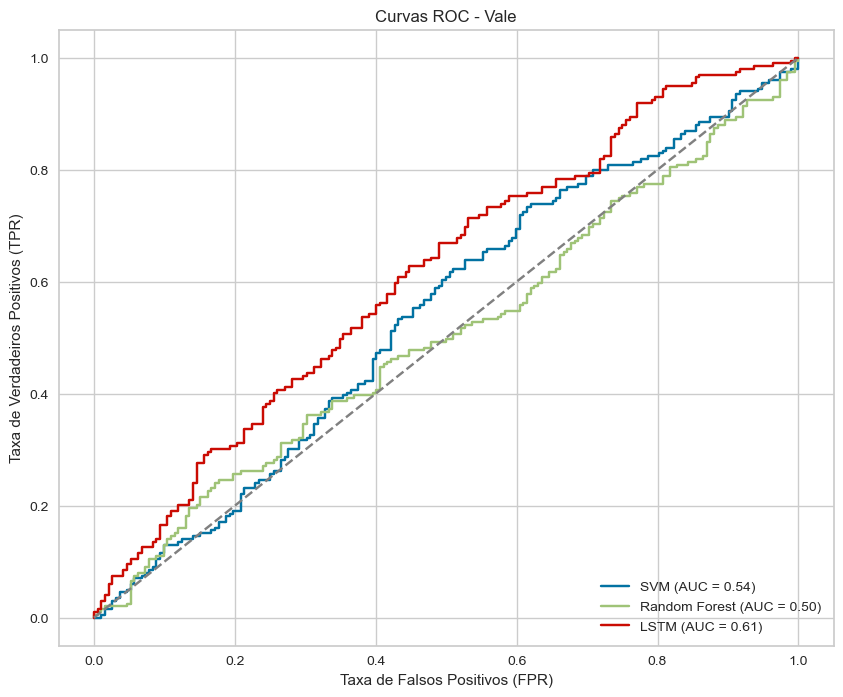

In [101]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Calcular escores/probabilidades
y_scores_svm = svm_model_test.decision_function(x_test_acao)  # SVM usa decision_function
y_prob_rf = rf_model_test.predict_proba(x_test_acao)[:, 1]    # RF usa predict_proba
y_prob_lstm = model_lstm.predict(x_test_lstm).ravel()         # LSTM já retorna probabilidade

# Calcular as curvas ROC
fpr_svm, tpr_svm, _ = roc_curve(y_test_acao, y_scores_svm)
fpr_rf, tpr_rf, _ = roc_curve(y_test_acao, y_prob_rf)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test_acao, y_prob_lstm)

# Calcular AUC (Área sob a curva ROC)
auc_svm = roc_auc_score(y_test_acao, y_scores_svm)
auc_rf = roc_auc_score(y_test_acao, y_prob_rf)
auc_lstm = roc_auc_score(y_test_acao, y_prob_lstm)

# Plotar as curvas ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {auc_lstm:.2f})')

# Adicionar linha de referência
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Configuração do gráfico
plt.title('Curvas ROC - Vale')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.legend(loc='lower right')

# Exibir o gráfico
plt.show()


In [102]:
from sklearn.metrics import (
    f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
)

def calcular_metricas(model_name, y_true, y_pred):
    """Calcula e exibe as métricas para um modelo."""
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    # Confusion matrix para calcular especificidade
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)

    # Exibir métricas
    print(f'\n{model_name} Metrics:')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall (Sensibilidade): {recall:.2f}')
    print(f'Specificity (Especificidade): {specificity:.2f}')

# Calcular e exibir as métricas para cada modelo
y_true = y_test_acao  # Valores reais

# SVM
y_pred_svm = svm_model_test.predict(x_test_acao)
calcular_metricas('SVM', y_true, y_pred_svm)

# Random Forest
y_pred_rf = rf_model_test.predict(x_test_acao)
calcular_metricas('Random Forest', y_true, y_pred_rf)

# LSTM
y_pred_lstm = (model_lstm.predict(x_test_lstm) > 0.5).astype("int32")
calcular_metricas('LSTM', y_true, y_pred_lstm)



SVM Metrics:
Accuracy: 0.54
F1 Score: 0.53
Precision: 0.55
Recall (Sensibilidade): 0.50
Specificity (Especificidade): 0.58

Random Forest Metrics:
Accuracy: 0.48
F1 Score: 0.52
Precision: 0.49
Recall (Sensibilidade): 0.55
Specificity (Especificidade): 0.42
13/13 [==============================] - 0s 12ms/step

LSTM Metrics:
Accuracy: 0.57
F1 Score: 0.56
Precision: 0.59
Recall (Sensibilidade): 0.54
Specificity (Especificidade): 0.60


In [103]:
# Calcular a acurácia de cada modelo
accuracy_svm = accuracy_score(y_test_acao, y_pred_svm)
accuracy_rf = accuracy_score(y_test_acao, y_pred_rf)
accuracy_lstm = accuracy_score(y_test_acao, y_pred_lstm)

# Exibir a acurácia de cada modelo
print(f"Acurácia do SVM: {accuracy_svm * 100:.2f}%")
print(f"Acurácia do Random Forest: {accuracy_rf * 100:.2f}%")
print(f"Acurácia do LSTM: {accuracy_lstm * 100:.2f}%")

Acurácia do SVM: 53.96%
Acurácia do Random Forest: 48.34%
Acurácia do LSTM: 57.29%
